# Implementing the Viterbi algorithm on trellises.


## Visualizing trellises
Author: Kristiina Oksner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#some methods that were used while implementing the algorithms; written by chatGPT
def generate_binary_strings(n):
    result = []
    generate_binary_strings_helper(n, "", result)
    return result

def generate_binary_strings_helper(n, current_string, result):
    if n == 0:
        result.append(current_string)
    else:
        generate_binary_strings_helper(n - 1, current_string + "0", result)
        generate_binary_strings_helper(n - 1, current_string + "1", result)

def number_to_letter(num):
    if 1 <= num <= 26:
        # Convert the number to the corresponding letter
        letter = chr(ord('A') + num - 1)
        return letter
    else:
        return "Number out of range for the alphabet"


def find_strings_with_letter(string_array, target_letter):
    return [s for s in string_array if target_letter in s]


def find_strings_starting_with_binary(array, target_start_binary):
    return [s for s in array if s[1:].startswith(target_start_binary)]


def find_last_1_in_column(matrix, col_index):
    num_rows = len(matrix)

    last_1_row_index = -1  # Initialize to -1, indicating no occurrence of 1 yet

    for row_index in range(num_rows):
        if matrix[row_index][col_index] == 1:
            last_1_row_index = row_index

    return last_1_row_index

def find_first_1_in_column(matrix, col_index):
    num_rows = len(matrix)

    for row_index in range(num_rows):
        if matrix[row_index][col_index] == 1:
            return row_index

    # If no occurrence of 1 in the column, return a value indicating no match
    return -1

def binary_multiply_no_carry(bin_num1, bin_num2):
    result = 0

    for i in range(len(bin_num1)):
        if bin_num1[i] == '1' and bin_num2[i] == '1':
            result += 1

    return result % 2  # Take the result modulo 2 to get the non-carry sum

def create_string_from_indices(arr, indices):
    selected_elements = [str(arr[i]) for i in indices]
    result_string = ''.join(selected_elements)
    return result_string


def extract_number_from_string(input_string):
    # Find the index where the digit part starts
    digit_start_index = next((i for i, char in enumerate(input_string) if char.isdigit()), len(input_string))

    # Check if the index is within the bounds of the string
    if digit_start_index < len(input_string):
        # Extract the numeric part from the string
        numeric_value = input_string[digit_start_index:]

        # If no digit is found, return 0
        return int(numeric_value) if numeric_value else 0

    # If the index is out of bounds, return 0
    return 0


def replace_first_digit(input_string, new_digit):
    # Find the index where the digit part starts
    digit_start_index = next((i for i, char in enumerate(input_string) if char.isdigit()), None)

    # Check if a digit was found
    if digit_start_index is not None:
        # Delete the first digit and add the new digit to the back
        modified_string = input_string[:digit_start_index] + input_string[digit_start_index + 1:] + str(new_digit)
        return modified_string
    else:
        return "No digit found after the letter."


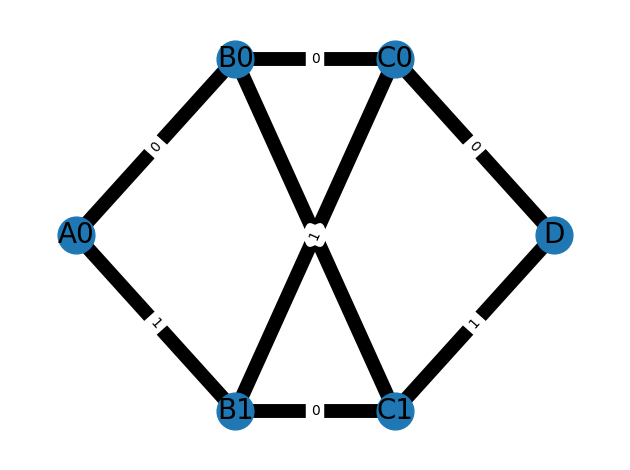

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C0'): 0, ('B0', 'C1'): 1, ('B1', 'C0'): 1, ('B1', 'C1'): 0, ('C0', 'D'): 0, ('C1', 'D'): 1}


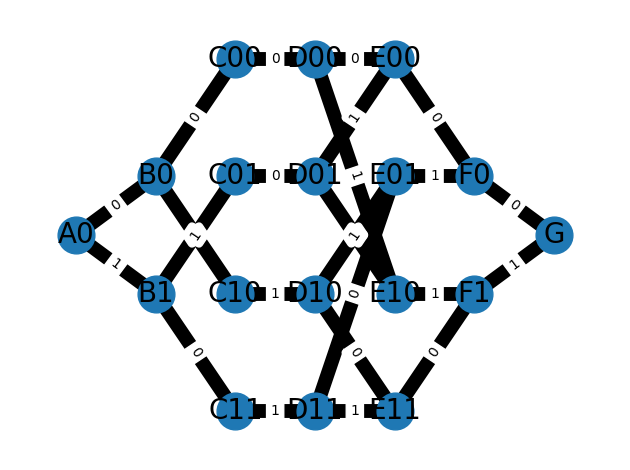

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 1, ('B1', 'C01'): 1, ('B1', 'C11'): 0, ('C00', 'D00'): 0, ('C01', 'D01'): 0, ('C10', 'D10'): 1, ('C11', 'D11'): 1, ('D00', 'E00'): 0, ('D00', 'E10'): 1, ('D01', 'E00'): 1, ('D01', 'E10'): 0, ('D10', 'E01'): 1, ('D10', 'E11'): 0, ('D11', 'E01'): 0, ('D11', 'E11'): 1, ('E00', 'F0'): 0, ('E01', 'F0'): 1, ('E10', 'F1'): 1, ('E11', 'F1'): 0, ('F0', 'G'): 0, ('F1', 'G'): 1}


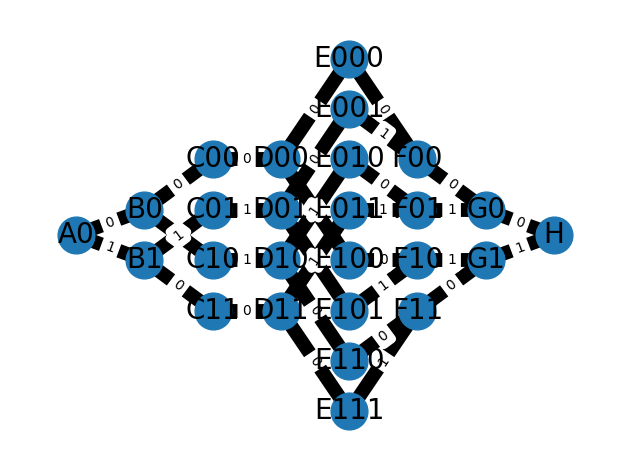

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 1, ('B1', 'C01'): 1, ('B1', 'C11'): 0, ('C00', 'D00'): 0, ('C01', 'D01'): 1, ('C10', 'D10'): 1, ('C11', 'D11'): 0, ('D00', 'E000'): 0, ('D00', 'E100'): 1, ('D01', 'E001'): 0, ('D01', 'E101'): 1, ('D10', 'E010'): 1, ('D10', 'E110'): 0, ('D11', 'E011'): 1, ('D11', 'E111'): 0, ('E000', 'F00'): 0, ('E001', 'F00'): 1, ('E010', 'F01'): 0, ('E011', 'F01'): 1, ('E100', 'F10'): 0, ('E101', 'F10'): 1, ('E110', 'F11'): 0, ('E111', 'F11'): 1, ('F00', 'G0'): 0, ('F01', 'G0'): 1, ('F10', 'G1'): 1, ('F11', 'G1'): 0, ('G0', 'H'): 0, ('G1', 'H'): 1}


In [3]:
#this function makes a trellis out of a generator matrix
def matrix_to_trellis(matrix): #the method takes in a generator matrix in minimal span form (the rows are sorted by the column index, where the last one appears in a row)
    G = nx.Graph()
    m=matrix.transpose()
    active_rows=[[]]
    #in order to avoid confusion, as the node names can be repeated, we added a letter in the beginning, which symbolises a layer of the node, starting with A=0
    G.add_node("A0", layer=0)
    for i in range(len(m)):
        #computing active rows at each layer
        how_many=0
        row=[]
        for j in range(len(m[i])):
            if i<find_last_1_in_column(m, j) and i>=find_first_1_in_column(m, j):
                    how_many+=1
                    row.append(j)
        active_rows.append(row)
        nodes=generate_binary_strings(how_many)
        #assinging edges with weights to each node of current active rows/nodes
        for k in range(len(nodes)):
            letter=number_to_letter(i+2)
            string=letter+str(nodes[k])
            G.add_node(string, layer=i+1)
            if i==0:
                G.add_edge("A0", string, weight=binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))
            elif i+1==len(m):
                letter=number_to_letter(i+1)
                nodes_fit=find_strings_with_letter(list(G.nodes), letter)
                for node in nodes_fit:
                    G.add_edge(node, string, weight=extract_number_from_string(node)+binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))
            elif active_rows[i+1]==active_rows[i]:
                letter=number_to_letter(i+1)
                old_node=letter+str(nodes[k])
                G.add_edge(old_node, string, weight=binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))
            else:
                letter=number_to_letter(i+1)
                nodes_fit=find_strings_with_letter(list(G.nodes), letter)
                if len(nodes_fit[0])<len(string):
                    new_nodes= find_strings_starting_with_binary(nodes_fit, nodes[k][1:])
                    for node in new_nodes:
                        G.add_edge(node, string, weight=binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))
                elif len(nodes_fit[0])>len(string):
                    new_nodes= find_strings_starting_with_binary(nodes_fit, nodes[k])
                    for node in new_nodes:
                        G.add_edge(node, string, weight=(int(node[-1])+binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))%2)
                else:
                    new_nodes= find_strings_starting_with_binary(nodes_fit, replace_first_digit(nodes[k], "0"))
                    for node in new_nodes:
                        G.add_edge(node, string, weight=binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))
                    new_nodes= find_strings_starting_with_binary(nodes_fit, replace_first_digit(nodes[k], "1"))
                    for node in new_nodes:
                        G.add_edge(node, string, weight=(1+binary_multiply_no_carry(nodes[k][::-1], create_string_from_indices(m[i], active_rows[i+1])))%2)

    #plotting the trellis
    pos = nx.multipartite_layout(G, subset_key="layer")

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=10)

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    #prints out all edges and the corresponding weights
    print(nx.get_edge_attributes(G,'weight'))
    return G

#Examples
#They were taken from Coding THeory course materials
matrix = np.array([[1, 1, 0], [0, 1, 1]])
trellis1 = matrix_to_trellis(matrix)

matrix2 = np.array([[1, 1, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0],[0, 0, 0, 1, 1, 1]])
trellis2 = matrix_to_trellis(matrix2)

matrix3 = np.array([[1,1,1,0,1,0,0], [0,1,1,1,0,1,0],[0,0,0,1,0,1,1 ]])
trellis3 = matrix_to_trellis(matrix3)

## Implementing Viterbi algorithm
Authors: Raido Rehepapp and Helena Sokk

In [4]:
def Vitrebi_algorithm(trellis, codeword):
    edges_with_weights = nx.get_edge_attributes(trellis,'weight')
    nodes_with_layers = nx.get_node_attributes(trellis,'layer')

    #print(edges_with_weights)
    #print(nodes_with_layers)

    #get the key with the maximum value in the dictionary
    max_key = max(nodes_with_layers, key=nodes_with_layers.get)

    # Get the maximum value in the dictionary
    max_layer = nodes_with_layers[max_key]

    #print(max_key)
    #print(max_layer)

    metrics = dict()
    path_for_node = dict()

    #we iterate over layers, in each layer we iterate over nodes in that layer
    for layer in range(max_layer+1):
        nodes_in_layer = [key for key, value in nodes_with_layers.items() if value == layer]
        #print(f"Nodes in current layer: {nodes_in_layer}")
        if layer == 0:
            #root node
            metrics[nodes_in_layer[0]] = 0
            path_for_node[nodes_in_layer[0]] = list()
        else:
            for node in nodes_in_layer:
                #print(f"node {node}")
                edges_where_selected_node_is_endpoint = [key for key, value in edges_with_weights.items() if key[1] == node]
                #print(f"Edges connecting to current node: {edges_where_selected_node_is_endpoint}")

                best_paths = list()
                #find all sums of last vertex and edge connecting
                for edge in edges_where_selected_node_is_endpoint:
                    edge_metric = (edges_with_weights[edge] + codeword[layer-1]) % 2
                    best_paths.append(metrics[edge[0]] + edge_metric)

                #find the best path
                index_min = np.argmin(best_paths)

                #set the best metric for current node
                metrics[node] = best_paths[index_min]

                #set the best bath for the current node
                best_last_node = edges_where_selected_node_is_endpoint[index_min][0]
                #print(path_for_node[best_last_node])
                best_path = path_for_node[best_last_node].copy()
                best_path.append(best_last_node)
                path_for_node[node] = best_path

    #print(metrics)
    #print(path_for_node)

    #path for the last element is the optimal path in the trellis
    optimal_path = list(path_for_node.values())[-1].copy()
    last_element = str(list(path_for_node.keys())[-1])
    optimal_path.append(last_element)
    #print(optimal_path)

    #we return the decoded bits
    decoded_bits = list()
    for i in range(len(optimal_path)-1):
        edge = edges_with_weights[(optimal_path[i],optimal_path[i+1])]
        decoded_bits.append(edge)
    return decoded_bits


trellis1_example_codeword = [1,1,1]
trellis1_decoded = Vitrebi_algorithm(trellis1, trellis1_example_codeword)
print(f"With codeword {trellis1_example_codeword} decoded sequence for trellis1: {trellis1_decoded}.")

trellis2_example_codeword = [1,0,1,1,0,1]
trellis2_decoded = Vitrebi_algorithm(trellis2, trellis2_example_codeword)
print(f"With codeword {trellis2_example_codeword} decoded sequence for trellis2: {trellis2_decoded}.")

trellis3_example_codeword = [1,0,1,0,1,0,1]
trellis3_decoded = Vitrebi_algorithm(trellis3, trellis3_example_codeword)
print(f"With codeword {trellis3_example_codeword} decoded sequence for trellis3: {trellis3_decoded}.")

With codeword [1, 1, 1] decoded sequence for trellis1: [1, 1, 0].
With codeword [1, 0, 1, 1, 0, 1] decoded sequence for trellis2: [1, 0, 1, 1, 0, 1].
With codeword [1, 0, 1, 0, 1, 0, 1] decoded sequence for trellis3: [1, 0, 0, 0, 1, 0, 1].


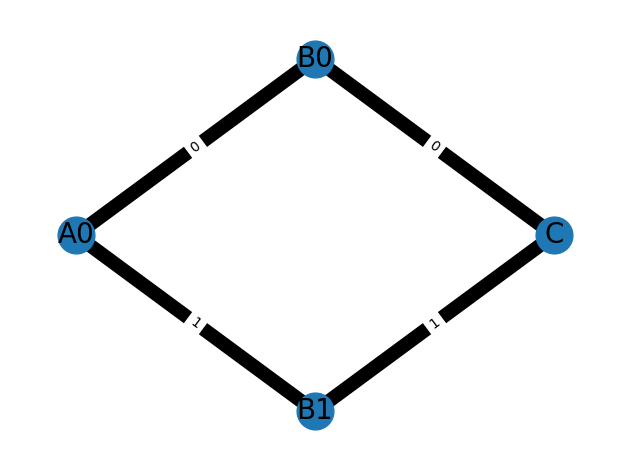

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C'): 0, ('B1', 'C'): 1}


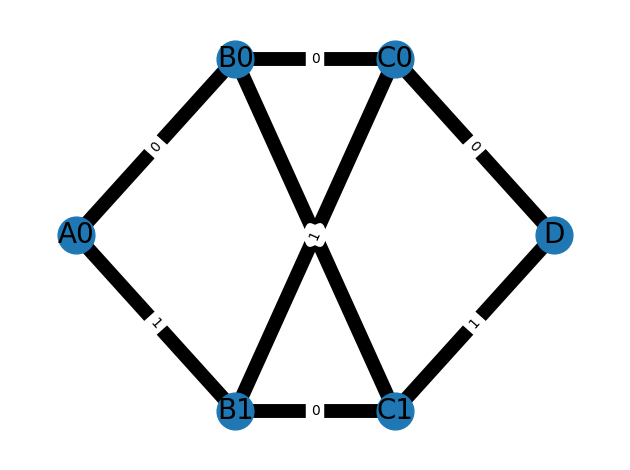

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C0'): 0, ('B0', 'C1'): 1, ('B1', 'C0'): 1, ('B1', 'C1'): 0, ('C0', 'D'): 0, ('C1', 'D'): 1}


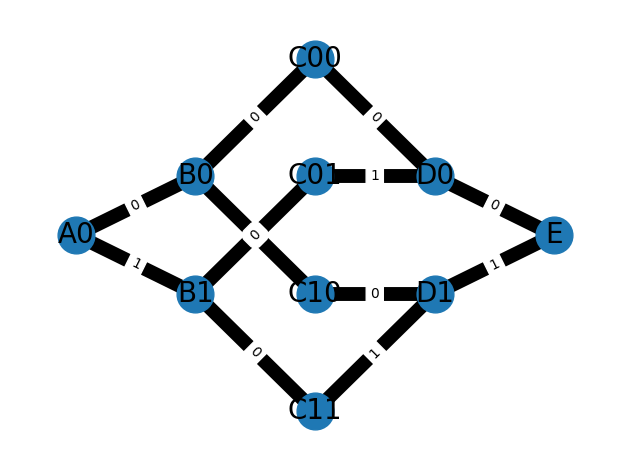

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D0'): 0, ('C01', 'D0'): 1, ('C10', 'D1'): 0, ('C11', 'D1'): 1, ('D0', 'E'): 0, ('D1', 'E'): 1}


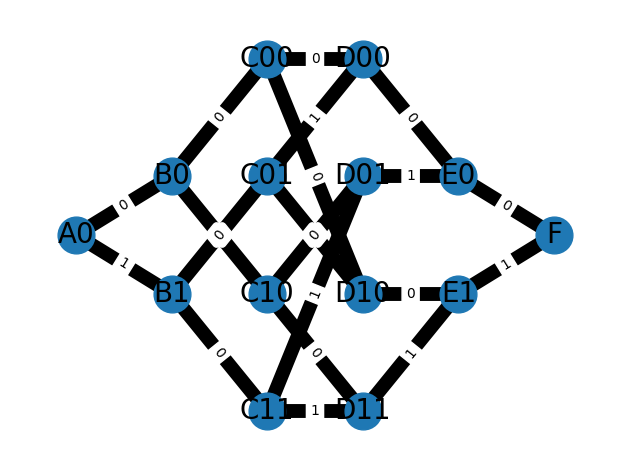

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D00'): 0, ('C00', 'D10'): 0, ('C01', 'D00'): 1, ('C01', 'D10'): 1, ('C10', 'D01'): 0, ('C10', 'D11'): 0, ('C11', 'D01'): 1, ('C11', 'D11'): 1, ('D00', 'E0'): 0, ('D01', 'E0'): 1, ('D10', 'E1'): 0, ('D11', 'E1'): 1, ('E0', 'F'): 0, ('E1', 'F'): 1}


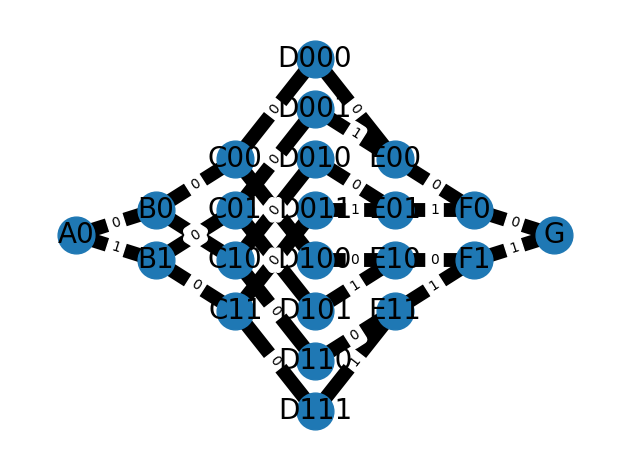

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E00'): 0, ('D001', 'E00'): 1, ('D010', 'E01'): 0, ('D011', 'E01'): 1, ('D100', 'E10'): 0, ('D101', 'E10'): 1, ('D110', 'E11'): 0, ('D111', 'E11'): 1, ('E00', 'F0'): 0, ('E01', 'F0'): 1, ('E10', 'F1'): 0, ('E11', 'F1'): 1, ('F0', 'G'): 0, ('F1', 'G'): 1}


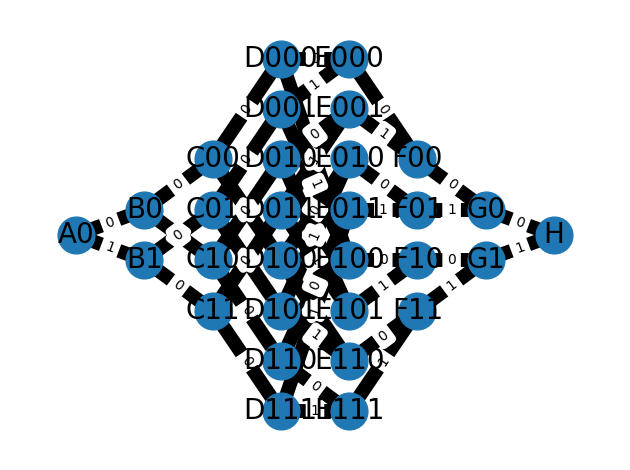

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E000'): 0, ('D000', 'E100'): 0, ('D001', 'E000'): 1, ('D001', 'E100'): 1, ('D010', 'E001'): 0, ('D010', 'E101'): 0, ('D011', 'E001'): 1, ('D011', 'E101'): 1, ('D100', 'E010'): 0, ('D100', 'E110'): 0, ('D101', 'E010'): 1, ('D101', 'E110'): 1, ('D110', 'E011'): 0, ('D110', 'E111'): 0, ('D111', 'E011'): 1, ('D111', 'E111'): 1, ('E000', 'F00'): 0, ('E001', 'F00'): 1, ('E010', 'F01'): 0, ('E011', 'F01'): 1, ('E100', 'F10'): 0, ('E101', 'F10'): 1, ('E110', 'F11'): 0, ('E111', 'F11'): 1, ('F00', 'G0'): 0, ('F01', 'G0'): 1, ('F10', 'G1'): 0, ('F11', 'G1'): 1, ('G0', 'H'): 0, ('G1', 'H'): 1}


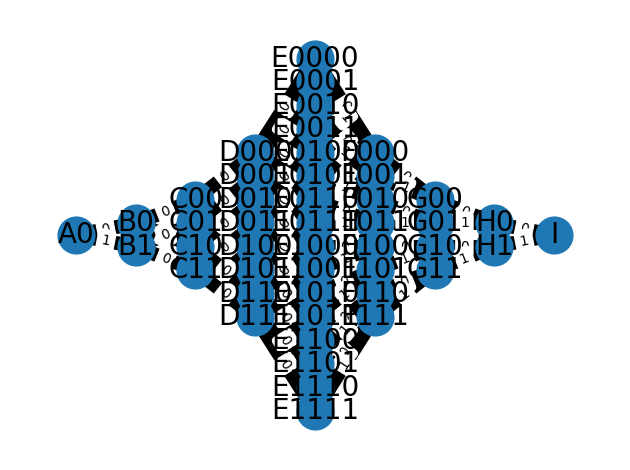

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F000'): 0, ('E0001', 'F000'): 1, ('E0010', 'F001'): 0, ('E0011', 'F001'): 1, ('E0100', 'F010'): 0, ('E0101', 'F010'): 1, ('E0110', 'F011'): 0, ('E0111', 'F011'): 1, ('E1000', 'F100'): 0, ('E1001', 'F100'): 1, ('E1010', 'F101'): 0, ('E1011', 'F101'): 1, ('E1100', 'F110'): 0, ('E1101', 'F110'): 1, ('E1110', 'F111'): 0, ('E1111', 'F111'): 1, ('F000', 'G00'): 0, ('F001', 

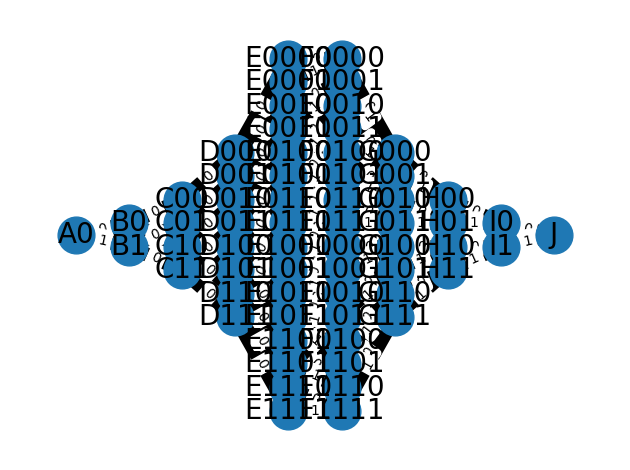

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F0000'): 0, ('E0000', 'F1000'): 0, ('E0001', 'F0000'): 1, ('E0001', 'F1000'): 1, ('E0010', 'F0001'): 0, ('E0010', 'F1001'): 0, ('E0011', 'F0001'): 1, ('E0011', 'F1001'): 1, ('E0100', 'F0010'): 0, ('E0100', 'F1010'): 0, ('E0101', 'F0010'): 1, ('E0101', 'F1010'): 1, ('E0110', 'F0011'): 0, ('E0110', 'F1011'): 0, ('E0111', 'F0011'): 1, ('E0111', 'F1011'): 1, ('E1000', 'F0

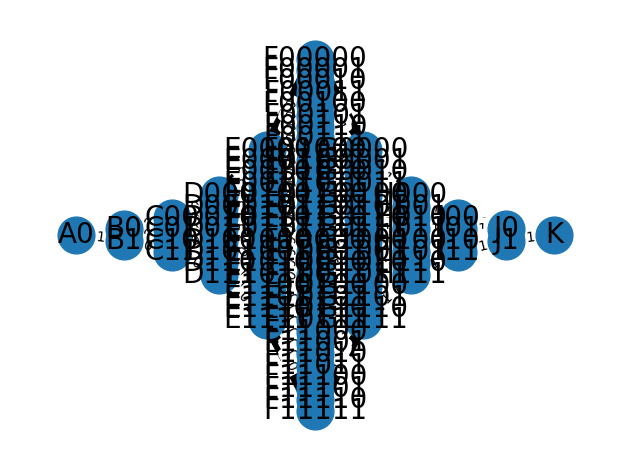

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

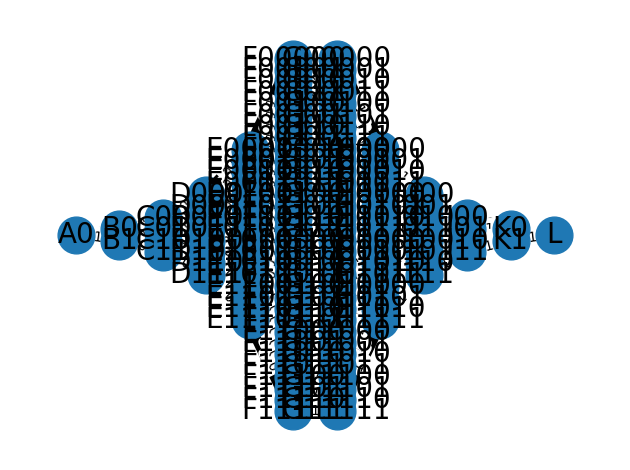

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

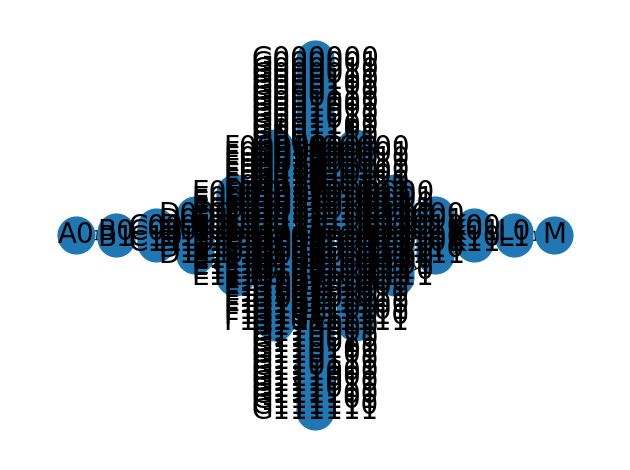

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

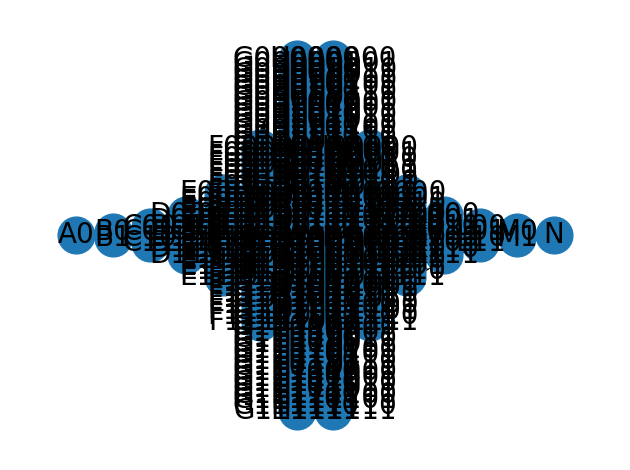

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

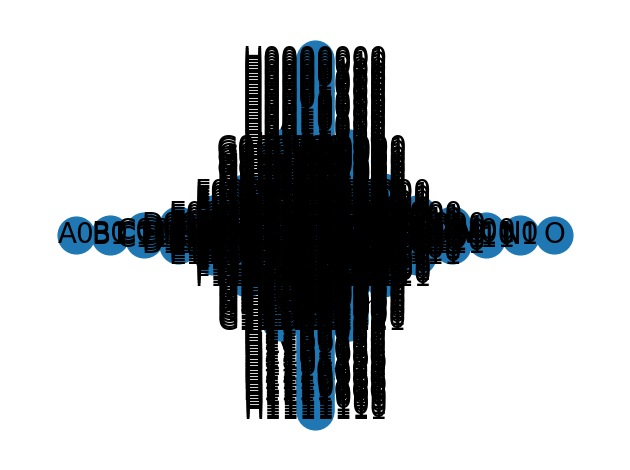

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

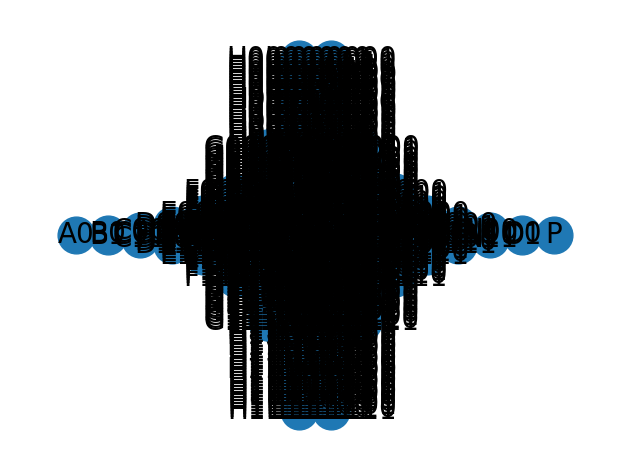

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

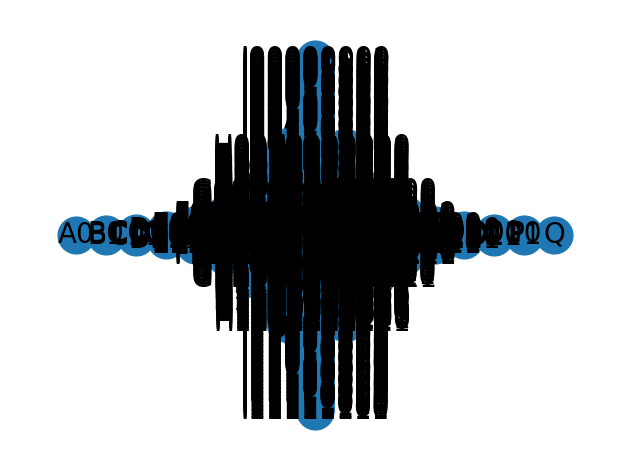

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

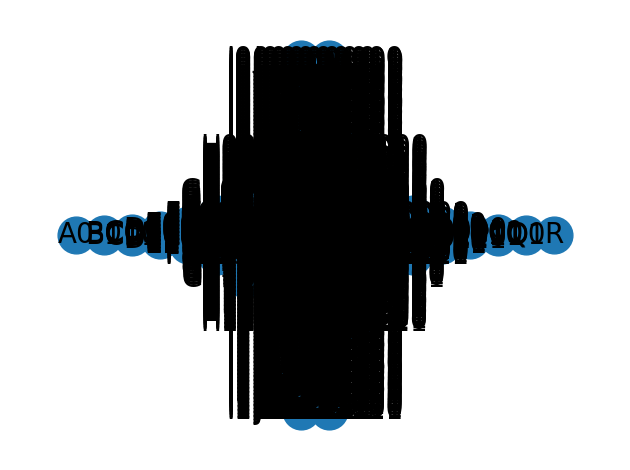

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

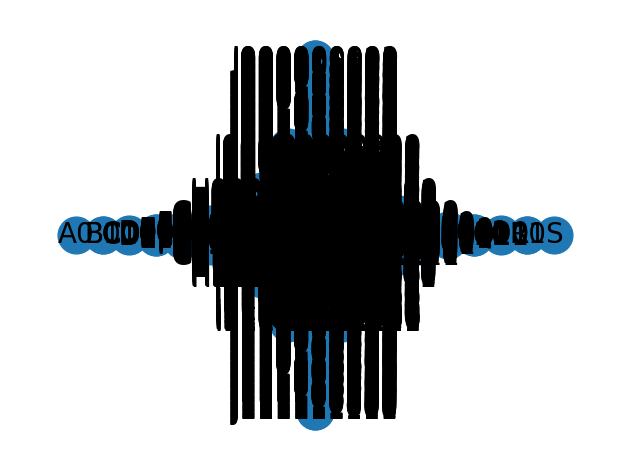

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

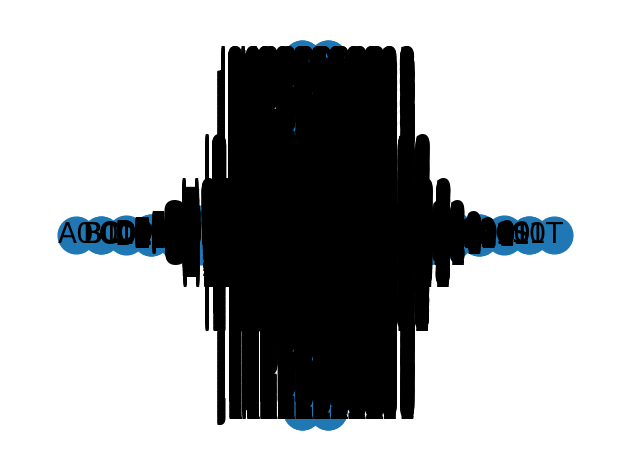

{('A0', 'B0'): 0, ('A0', 'B1'): 1, ('B0', 'C00'): 0, ('B0', 'C10'): 0, ('B1', 'C01'): 0, ('B1', 'C11'): 0, ('C00', 'D000'): 0, ('C00', 'D100'): 0, ('C01', 'D001'): 0, ('C01', 'D101'): 0, ('C10', 'D010'): 0, ('C10', 'D110'): 0, ('C11', 'D011'): 0, ('C11', 'D111'): 0, ('D000', 'E0000'): 0, ('D000', 'E1000'): 0, ('D001', 'E0001'): 0, ('D001', 'E1001'): 0, ('D010', 'E0010'): 0, ('D010', 'E1010'): 0, ('D011', 'E0011'): 0, ('D011', 'E1011'): 0, ('D100', 'E0100'): 0, ('D100', 'E1100'): 0, ('D101', 'E0101'): 0, ('D101', 'E1101'): 0, ('D110', 'E0110'): 0, ('D110', 'E1110'): 0, ('D111', 'E0111'): 0, ('D111', 'E1111'): 0, ('E0000', 'F00000'): 0, ('E0000', 'F10000'): 0, ('E0001', 'F00001'): 0, ('E0001', 'F10001'): 0, ('E0010', 'F00010'): 0, ('E0010', 'F10010'): 0, ('E0011', 'F00011'): 0, ('E0011', 'F10011'): 0, ('E0100', 'F00100'): 0, ('E0100', 'F10100'): 0, ('E0101', 'F00101'): 0, ('E0101', 'F10101'): 0, ('E0110', 'F00110'): 0, ('E0110', 'F10110'): 0, ('E0111', 'F00111'): 0, ('E0111', 'F10111'): 

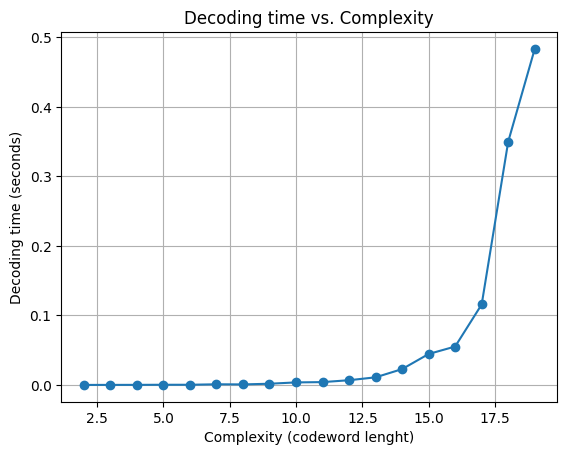

In [5]:
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

'''
This part is to compare how trellis complexity and codeword length affects decoding time
'''

def matrix_for_plot(n):
    if n%2==0:
        matrix=np.zeros((int(n/2),n))
        i=0
        for k in range(len(matrix[0])):
            if k== n/2:
                i=0
                matrix[i][k]=1
                i+=1
            else:
                matrix[i][k]=1
                i+=1
    else:
        matrix=np.zeros((math.ceil(n/2),n))
        i=0
        for k in range(len(matrix[0])):
            if k== int(n/2):
                matrix[i][k]=1
                i=0
                matrix[i][k]=1
                i+=1
            else:
                matrix[i][k]=1
                i+=1
    return matrix

def is_connected(graph):
  #check if the trellis is connected
    return nx.is_connected(graph)

def generate_connected_trellis(complexity):
    connected = False
    while not connected:
        matrix_variable_complexity = np.random.randint(2, size=(3, complexity))
        print(matrix_variable_complexity)

        trellis_variable_complexity = matrix_to_trellis(matrix_variable_complexity)

        # check if the trellis is connected
        connected = is_connected(trellis_variable_complexity)

    return trellis_variable_complexity

complexity_values = []
decoding_times = []

#Examples were taken from Coding Theory cource and https://proofwiki.org/wiki/Standard_Generator_Matrix_for_Linear_Code/Examples
#Some examples were generated by hand
matrices=[np.array([[1,1]]),np.array([[1, 1, 0], [0, 1, 1]]),np.array([[1, 1,1, 0], [0, 1, 1, 1]]),np.array([[1, 0, 1, 1, 0], [0, 1, 0,1, 0],[0, 0, 1, 1, 1]]),np.array([[1, 1, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0],[0, 0, 0, 1, 1, 1]]),np.array([[1,1,1,0,1,0,0], [0,1,1,1,0,1,0],[0,0,0,1,0,1,1 ]]),np.array([[1,1,1,1,1,1,1,1]])]

# complexity by changing the number of columns in the matrix
#for matrix in matrices:
for i in range(2,20):
    # new trellis
    #trellis_variable_complexity = matrix_to_trellis(matrix)
    trellis_variable_complexity = matrix_to_trellis(matrix_for_plot(i))

    # random codeword with length equal to the complexity
    codeword_variable_complexity = np.random.randint(2, size=i).tolist()

    # measure decoding time
    start_time = time.time()
    Vitrebi_algorithm(trellis_variable_complexity, codeword_variable_complexity)
    end_time = time.time()
    decoding_time = end_time - start_time

    complexity_values.append(i)
    decoding_times.append(decoding_time)

# visualization
plt.plot(complexity_values, decoding_times, marker='o')
plt.xlabel('Complexity (codeword lenght)')
plt.ylabel('Decoding time (seconds)')
plt.title('Decoding time vs. Complexity')
plt.grid(True)
plt.show()